In [1]:
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm as WN
from torch.optim.lr_scheduler import MultiStepLR, StepLR,ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from ipywidgets import interact
types=torch.float64
torch.set_default_dtype(types)

In [26]:
class PDE_with_boundary():
    """Class for solving a PDE with Neumann and Dirichlet conditions using DGM"""
    def __init__(self, eqn_config):
        self.dim=eqn_config["dim"]
        self.total_time=eqn_config["total_time"]
        self.lambd = 4.0
        self.model=ResNetLikeDGM(3,1)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.01,weight_decay=0.00001)
        self.scheduler2 = StepLR(self.optimizer,step_size=5000,gamma=0.5)
        self.scheduler=ReduceLROnPlateau(self.optimizer, 'min',factor=0.8,threshold=1e-3,patience=15)
        
    def interior_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.random.uniform(size=(num_sample,self.dim))
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def dirichlet_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.stack((np.ones(num_sample),np.random.uniform(size=num_sample)*0.2),axis=1)
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def neumann_sample(self,num_sample):
        Ns=int(num_sample/4)
        iz=np.stack((np.zeros(Ns),np.random.uniform(size=Ns)),axis=1)
        niz=np.repeat([[1.0,0.0]],Ns,0)
        up=np.stack((np.random.uniform(size=Ns),np.ones(Ns)),axis=1)
        nup=np.repeat([[0.0,1.0]],Ns,0)
        down=np.stack((np.random.uniform(size=Ns),np.zeros(Ns)),axis=1)
        ndown=np.repeat([[0.0,-1.0]],Ns,0)
        der=np.stack((np.ones(Ns),0.2+np.random.uniform(size=Ns)*0.8),axis=1)
        nder=np.repeat([[-1.0,0.0]],Ns,0)
        x=np.concatenate((iz,up,down,der))
        t=np.random.uniform(low=0,high=self.total_time,size=[x.shape[0],1])
        return torch.tensor(np.hstack((t,x)),requires_grad=True),torch.tensor(np.concatenate((niz,nup,ndown,nder)))
    
    def terminal_sample(self,num_sample):
        T=np.ones(shape=[num_sample,1])*self.total_time
        x=np.random.uniform(size=[num_sample,self.dim])
        return torch.tensor(np.hstack((T,x)),requires_grad=True)
        
    def loss(self,interior_sample,neumann_sample,dirichlet_sample,terminal_sample):
        
        V=self.model(interior_sample)
        dV=torch.autograd.grad(V,interior_sample, grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_t=dV[:,0]
        V_x=dV[:,1:]
        V_xx=torch.autograd.grad(dV,interior_sample,grad_outputs=torch.ones_like(dV),retain_graph=True,create_graph=True,only_inputs=True)[0][:,1:]
        diff_V=self.Lv(interior_sample, V_t,V_x,V_xx)
        L1=torch.mean(torch.square(diff_V))
        
        x_neumann,n_neumann=neumann_sample
        Vn=self.model(x_neumann)
        dVn=torch.autograd.grad(Vn,x_neumann, grad_outputs=torch.ones_like(Vn),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_nx=dVn[:,1:]
        normaldVn=torch.sum(V_nx*n_neumann,axis=1)
        L2=torch.mean(torch.square(normaldVn-self.h_n(x_neumann)))
        
        Vd=self.model(dirichlet_sample)
        L3=torch.mean(torch.square(Vd-self.h_d(dirichlet_sample)))
        
        Vter=self.model(terminal_sample)
        L4=torch.mean(torch.square(Vter-self.g_Tf(terminal_sample)))
        
        return L1+L2+2*L3+L4
    
    def h_n(self,x):
        """Neumann boundary condition"""
        return torch.zeros(x.shape[0])
    
    def h_d(self,x):
        """Dirichlet boundary condition"""
        return -1.0*torch.ones(x.shape[0])
    
    def g_Tf(self,x):
        """Terminal condition"""
        lens=x[:,1:]-torch.tensor(np.repeat([[1.0,0.05]],x.shape[0],0))
        #return torch.zeros(x.shape[0])
        return torch.sqrt(torch.sum(lens*lens,axis=1))
        
    def Lv(self, x, V_t,V_x,V_xx):
        #return V_t-0.5*torch.sum(V_xx,axis=1)
        return V_t+torch.sum(V_xx,axis=1)-self.lambd*torch.sum(V_x*V_x,axis=1)
    
    def train(self,Nsteps):
        start_time = time.time()
        training_history = []
        interior_valid = self.interior_sample(512)
        neumann_valid= self.neumann_sample(512)
        dirichlet_valid=self.dirichlet_sample(512)
        terminal_valid=self.terminal_sample(512)

        # begin sgd iteration
        for step in range(Nsteps+1):
            #print(step)
            interior = self.interior_sample(512)
            neumann= self.neumann_sample(512)
            dirichlet=self.dirichlet_sample(512)
            terminal=self.terminal_sample(512)
            loss=self.loss(interior,neumann,dirichlet,terminal)
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            for _ in range(10):
                
                self.optimizer.step()
                self.scheduler.step(loss)
            
            
            if step % 200==0:
                self.scheduler2.step()
                loss = self.loss(interior_valid,neumann_valid,dirichlet_valid,terminal_valid).detach().numpy()
                #y_init = self.y_0.detach().numpy()[0]
                elapsed_time = time.time() - start_time
                training_history.append([step, loss, elapsed_time])
                print("Epoch ",step," time ", elapsed_time," loss ", loss)

        return np.array(training_history)
    def save_model(self,file_name):
        torch.save(self.model.state_dict(), file_name)
    def load_model(self,file_name):
        self.model.load_state_dict(torch.load(file_name))

In [27]:

sigma = torch.tanh

class DGMCell(nn.Module):
    def __init__(self, d, M, growing, weight_norm):
        super().__init__()
        wn = WN if weight_norm else lambda x: x

        self.Uz = wn(nn.Linear(d, M, bias=False))
        self.Ug = wn(nn.Linear(d, M, bias=False))
        self.Ur = wn(nn.Linear(d, M, bias=False))
        self.Uh = wn(nn.Linear(d, M, bias=False))

        self.Wz = wn(nn.Linear(M, M))
        self.Wg = wn(nn.Linear(M, M))
        self.Wr = wn(nn.Linear(M, M))
        self.Wh = wn(nn.Linear(M, M))

        self.A = (lambda x: x) if growing else sigma

    def forward(self, SX):
        S, X = SX
        Z = sigma(self.Uz(X) + self.Wz(S))
        G = sigma(self.Ug(X) + self.Wg(S))
        R = sigma(self.Ur(X) + self.Wr(S))
        H = self.A(self.Uh(X) + self.Wh(S*R))
        S = (1-G)*H + Z*S

        return S, X


def _set_convert(flag):
    if flag: return lambda X: X[0]
    return lambda X: torch.stack(X, -1)


class ResNetLikeDGM(nn.Module):
    """
    DGM algorithm from https://arxiv.org/pdf/1708.07469.pdf
    Args:
    -----
    d_in and d_out- input and ouput dimensions of the problem
    M - layers' width
    L - recurrency depth
    """
    def __init__(
            self, d_in, d_out, M=50, L=3,
            growing=False, as_array=True, weight_norm=False):
        super().__init__()
        wn = WN if weight_norm else lambda x: x
        self.W0 = wn(nn.Linear(d_in, M))
        self.W1 = wn(nn.Linear(M, d_out))
        self._convert = _set_convert(as_array)

        self.layers = []
        for l in range(L):
            self.layers.append(DGMCell(d_in, M, growing, weight_norm))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, *X):
        X = self._convert(X)
        S = sigma(self.W0(X))
        S,_ = self.layers((S, X))
        return self.W1(S).squeeze_(-1)


In [28]:
pde=PDE_with_boundary({"dim":2,"total_time":1.0,"Ndis":20})

In [5]:
#pde.save_model('calor.pth')

In [29]:
pde.train(2000)
#pde.load_model('calor.pth')

Epoch  0  time  0.1169590950012207  loss  15325.509624446422
Epoch  200  time  12.354637384414673  loss  1.8791898291941074
Epoch  400  time  24.465131521224976  loss  1.8781368681763608
Epoch  600  time  36.6044225692749  loss  1.8758397461081473
Epoch  800  time  48.72477650642395  loss  1.8714426013573664
Epoch  1000  time  60.857877016067505  loss  1.8640535658000017
Epoch  1200  time  72.97913217544556  loss  1.85291593609255
Epoch  1400  time  85.07931017875671  loss  1.8380625903146084
Epoch  1600  time  97.2043833732605  loss  1.8205576432670292
Epoch  1800  time  109.44895553588867  loss  1.801889418482604
Epoch  2000  time  121.59119772911072  loss  1.7830732335281332


array([[0.00000000e+00, 1.53255096e+04, 1.16959095e-01],
       [2.00000000e+02, 1.87918983e+00, 1.23546374e+01],
       [4.00000000e+02, 1.87813687e+00, 2.44651315e+01],
       [6.00000000e+02, 1.87583975e+00, 3.66044226e+01],
       [8.00000000e+02, 1.87144260e+00, 4.87247765e+01],
       [1.00000000e+03, 1.86405357e+00, 6.08578770e+01],
       [1.20000000e+03, 1.85291594e+00, 7.29791322e+01],
       [1.40000000e+03, 1.83806259e+00, 8.50793102e+01],
       [1.60000000e+03, 1.82055764e+00, 9.72043834e+01],
       [1.80000000e+03, 1.80188942e+00, 1.09448956e+02],
       [2.00000000e+03, 1.78307323e+00, 1.21591198e+02]])

In [20]:
def proyectar_adentro(X):
    x=X[0]
    y=X[1]
    if x<0.0:
        x=0.0
    elif x>1.0:
        x=1.0
    if y<0:
        y=0.0
    elif y>1.0:
        y=1.0
    return x,y
    
        
def simular_trayectoria(pde,X0,dt):
    t=0.0
    x=[X0[0]]
    y=[X0[1]]
    while t<=1:
        pos=torch.tensor([t,x[-1],y[-1]],requires_grad=True)
        u=pde.model(pos)
        alpha=-np.sqrt(pde.lambd)*torch.autograd.grad(u,pos)[0]
        xnew=x[-1]+2*pde.lambd*alpha[1]*dt+np.sqrt(2)*np.random.normal(loc=0.0,scale=np.sqrt(dt))
        ynew=y[-1]+2*pde.lambd*alpha[2]*dt+np.sqrt(2)*np.random.normal(loc=0.0,scale=np.sqrt(dt))
        xn,yn=proyectar_adentro([xnew,ynew])
        x.append(xn)
        y.append(yn)
        if abs(x[-1]-1.0)<1e-5 and y[-1]<0.2:
            break
        t+=dt
    return x,y        

(-0.05, 1.05, 0.004289623899875507, 1.0474147798142917)

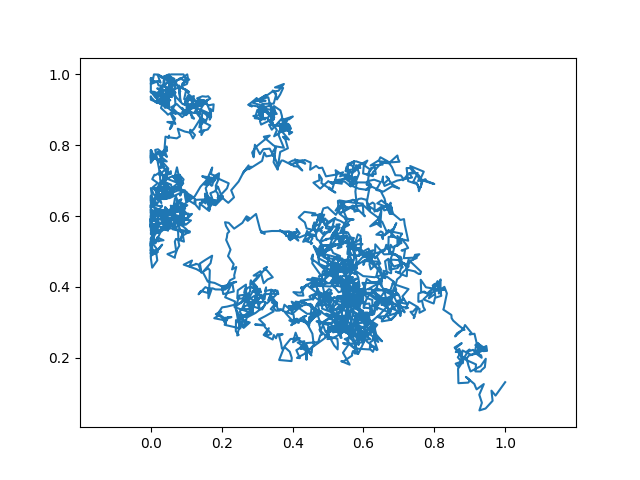

In [25]:
x,y=simular_trayectoria(pde,[0.1,0.9],0.0001)
figpla = plt.figure()
axpla = figpla.add_subplot(111)
axpla.plot(x,y)
axpla.axis('equal')

interactive(children=(FloatSlider(value=1.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.draw(t)>

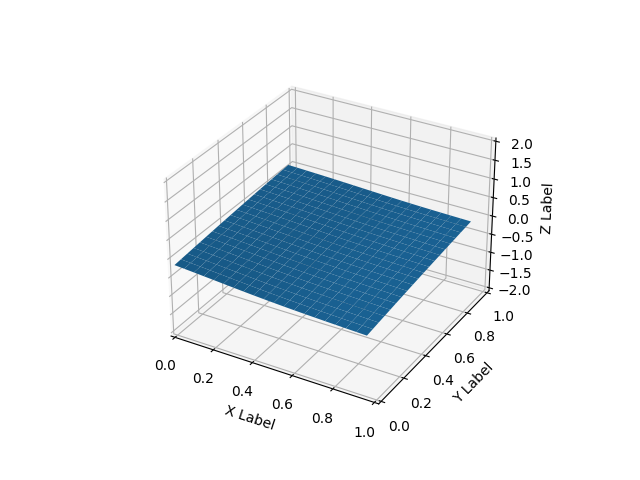

In [12]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 1.0, 0.05)
X, Y = np.meshgrid(x, y)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(-5,5)

def draw(t):  
    ax.cla()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(-2,2)
    times=t*np.ones(np.ravel(X).shape[0])
    tes=torch.tensor(np.stack((times,np.ravel(X), np.ravel(Y)),axis=1))
    zs =pde.model(tes).detach().numpy()
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)

interact(draw,t=widgets.FloatSlider(min=0, max=1.0, step=0.01, value=10))
